In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans

%matplotlib inline

In [3]:
def hdist(l, r):
    return (l/l.sum() - r/r.sum()).abs().sum()/2

In [4]:
def cluster_bins(l, r, cl):
    cl_l = cl.fit_predict(l.reshape(-1, 1))
    cl_r = cl.fit_predict(r.reshape(-1, 1))

    h_l = pd.Series(cl_l).value_counts()
    h_r = pd.Series(cl_r).value_counts()
    return h_l, h_r

In [5]:
def percentile_bins(l, r, percentiles):
    perc_l = np.percentile(l, percentiles)
    perc_l = pd.Series(perc_l, index=percentiles)

    perc_l_dd = perc_l.drop_duplicates(keep='last')
    ph_l = pd.cut(l, bins=perc_l_dd).value_counts()
    ph_r = pd.cut(r, bins=perc_l_dd).value_counts()
    return ph_l, ph_r

In [6]:
from tdigest import TDigest

def tdigest_bins(l, r, percentiles):
    digest_l = TDigest()
    digest_l.batch_update(l)
    perc_l = [digest_l.percentile(p) for p in percentiles]
    perc_l = pd.Series(perc_l, index=percentiles)

    perc_l_dd = perc_l.drop_duplicates(keep='last')
    ph_l = pd.cut(l, bins=perc_l_dd).value_counts()
    ph_r = pd.cut(r, bins=perc_l_dd).value_counts()
    return ph_l, ph_r

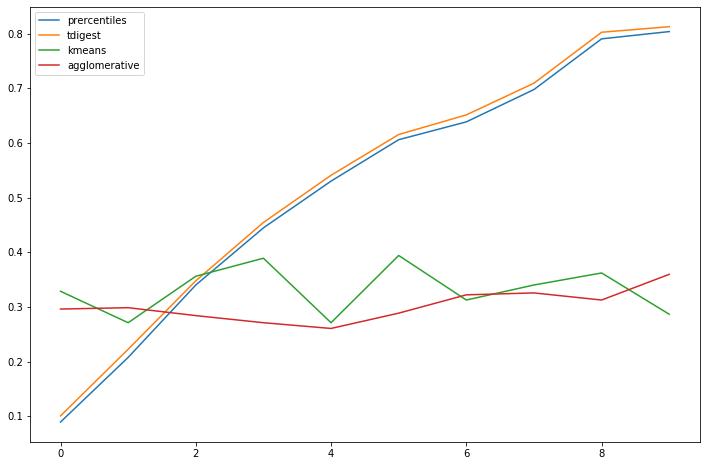

In [10]:
data = [
    np.random.normal(loc=n, scale=5, size=2000)
    for n in np.arange(11)*np.arange(11)
]

diffs_p = pd.Series(
    hdist(*percentile_bins(l, r, np.arange(1, 100, 3)))
    for l, r in zip(data[:-1], data[1:]))
diffs_td = pd.Series(
    hdist(*tdigest_bins(l, r, np.arange(1, 100, 3)))
    for l, r in zip(data[:-1], data[1:]))
diffs_km = pd.Series(
    hdist(*cluster_bins(l, r, KMeans(n_clusters=20)))
    for l, r in zip(data[:-1], data[1:]))
diffs_agg = pd.Series(
    hdist(*cluster_bins(l, r, AgglomerativeClustering(n_clusters=20)))
    for l, r in zip(data[:-1], data[1:]))

data = {
    'prercentiles': diffs_p,
    'tdigest': diffs_td+.01,
    'kmeans': diffs_km,
    'agglomerative': diffs_agg
}

pd.DataFrame(data).plot.line(figsize=(12, 8));